<a href="https://colab.research.google.com/github/AdamClarkStandke/GenerativeDeepLearning/blob/main/GenerativeDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Diffusion Probabilistic Models

As author [Aakash Kumar Nain](https://twitter.com/A_K_Nain) states in the [tutorial](https://keras.io/examples/generative/ddpm/):

> We implement the [Denoising Diffusion Probabilistic Models paper or DDPMs](https://arxiv.org/pdf/2006.11239.pdf) for short in this code example. It was the first paper demonstrating the use of diffusion models for generating high-quality images. The authors proved that a certain parameterization of diffusion models reveals an equivalence with denoising score matching over multiple noise levels during training and with annealed Langevin dynamics during sampling that generates the best quality results.

And as authors of [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf) state:

> This paper presents progress in diffusion probabilistic models. A diffusion probabilistic model (which we will call a “diffusion model” for brevity) is a parameterized Markov chain trained using variational inference to produce samples matching the data after finite time [see figure below]. Transitions of this chain are learned to reverse a diffusion process, which is a Markov chain that gradually adds noise to the data in the opposite direction of sampling until signal is destroyed. When the diffusion consists of small amounts of Gaussian noise, it is sufficient to set the sampling chain transitions to conditional Gaussians too, allowing for a particularly simple neural network parameterization.

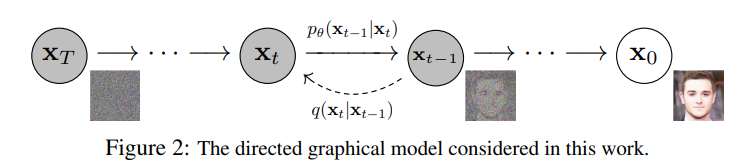




> The following Keras code works on training and optimizing the varience reduction in L as given by the following equation and terms:



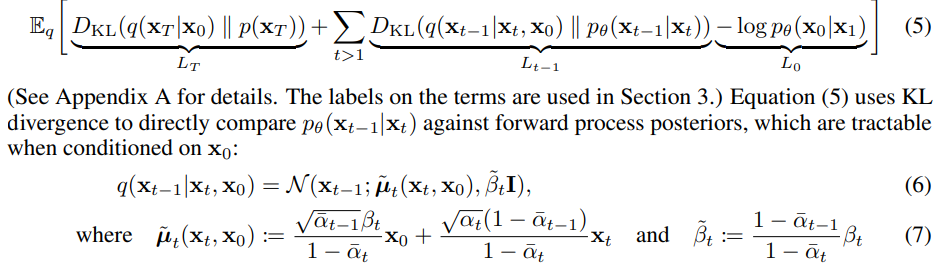

In [ ]:
# Importing libraries, Setting fixed values/hyperparms and download/procesing Data

import math
import numpy as np
import matplotlib.pyplot as plt

# Requires TensorFlow >=2.11 for the GroupNormalization layer.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
batch_size = 32
num_epochs = 1  # Just for the sake of demonstration
total_timesteps = 1000
norm_groups = 8  # Number of groups used in GroupNormalization layer
learning_rate = 2e-4

img_size = 64
img_channels = 3
clip_min = -1.0
clip_max = 1.0

first_conv_channels = 64
channel_multiplier = [1, 2, 4, 8]
widths = [first_conv_channels * mult for mult in channel_multiplier]
has_attention = [False, False, True, True]
num_res_blocks = 2  # Number of residual blocks

dataset_name = "oxford_flowers102"
splits = ["train"]

# Load the dataset
(ds,) = tfds.load(dataset_name, split=splits, with_info=False, shuffle_files=True)


def augment(img):
    """Flips an image left/right randomly."""
    return tf.image.random_flip_left_right(img)


def resize_and_rescale(img, size):
    """Resize the image to the desired size first and then
    rescale the pixel values in the range [-1.0, 1.0].

    Args:
        img: Image tensor
        size: Desired image size for resizing
    Returns:
        Resized and rescaled image tensor
    """

    height = tf.shape(img)[0]
    width = tf.shape(img)[1]
    crop_size = tf.minimum(height, width)

    img = tf.image.crop_to_bounding_box(
        img,
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # Resize
    img = tf.cast(img, dtype=tf.float32)
    img = tf.image.resize(img, size=size, antialias=True)

    # Rescale the pixel values
    img = img / 127.5 - 1.0
    img = tf.clip_by_value(img, clip_min, clip_max)
    return img


def train_preprocessing(x):
    img = x["image"]
    img = resize_and_rescale(img, size=(img_size, img_size))
    img = augment(img)
    return img


train_ds = (
    ds.map(train_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .shuffle(batch_size * 2)
    .prefetch(tf.data.AUTOTUNE)
)

### 1.   $L_{T}$ and $L_{t-1}$ terms of Equation 5

To make sense of the code in light of the paper, I will try and detail aspects of the paper in relation to different code sections of the Gaussian Diffusion Model as written by Aakash Kumar Nain with respect to $L_{T}$ and $L_{t-1}$ of Equation 5.

*   (1) Calculating the betas
> As the authors of Denoising Diffusion Probabilistic Models state in regards to the forward process i.e., $L_{T}$: We ignore the fact that the forward process variances βₜ are learnable by reparameterization and instead fix them to constants...[w]e set the forward process variances to constants increasing linearly from β1 = 10^−4 to βₜ = 0.02.

This is detailed by the following code snippet:

```
class GaussianDiffusion:
    """Gaussian diffusion utility.

    Args:
        beta_start: Start value of the scheduled variance
        beta_end: End value of the scheduled variance
        timesteps: Number of time steps in the forward process
    """

    def __init__(
        self,
        beta_start=1e-4,
        beta_end=0.02,
        timesteps=1000,
        clip_min=-1.0,
        clip_max=1.0,
    ):
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps
        self.clip_min = clip_min
        self.clip_max = clip_max

        # Define the linear variance schedule
        self.betas = betas = np.linspace(
            beta_start,
            beta_end,
            timesteps,
            dtype=np.float64,  # Using float64 for better precision
        )
```


*   (2) Calculating alphas, alpha bars, and sqrt of alpha bars for diffusion i.e. q as modeled by $q(x_{t}|x_{0})$

> As the authors of Denoising Diffusion Probabilistic Models state:
using the notation:\begin{align}
\alpha_t:= 1-\beta_t \ and \ \bar{\alpha_t}:=\prod_{s=1}^{t}\alpha_{s}
\end{align}

This is detailed by the following code snippet:

```
alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

self.betas = tf.constant(betas, dtype=tf.float32)
self.alphas_cumprod = tf.constant(alphas_cumprod, dtype=tf.float32)
self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype=tf.float32)
```

*   (3) Calculating mean, varience and coefficents for diffusion i.e., q as modeled by $q(x_{t-1}| x_{t}, x_{0})$

> As the authors of Denoising Diffusion Probabilistic Models state:
\begin{align}q(x_{t-1}|x_{t}, x_{0})=N(x_{t-1};\tilde{\mu_{t}}(x_t, x_0), \tilde{\beta_t}I),where\  \tilde{\mu_{t}}(x_t, x_0):= \frac{\sqrt{\bar{\alpha_{t-1}}}\beta_t}{1-\bar{\alpha_{t}}}x_{0}+\frac{\sqrt{\alpha_{t}}(1-\bar{\alpha_{t-1}})}{1-\bar{\alpha_{t}}}x_{t} \ and \ \tilde{\beta_t}:=\frac{1-\bar{\alpha_{t-1}}}{1-\bar{\alpha_{t}}}\beta_t\end{align}

This is detailed by the following code snippet:
```
# Calculations for posterior q(x_{t-1} | x_t, x_0)

posterior_variance = (
    betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
)
self.posterior_variance = tf.constant(posterior_variance, dtype=tf.float32)

# Log calculation clipped because the posterior variance is 0 at the beginning
# of the diffusion chain
self.posterior_log_variance_clipped = tf.constant(
    np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf.float32
)

self.posterior_mean_coef1 = tf.constant(
    betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
)

self.posterior_mean_coef2 = tf.constant(
    (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod),
          dtype=tf.float32,
)

def q_posterior(self, x_start, x_t, t):
        """Compute the mean and variance of the diffusion
        posterior q(x_{t-1} | x_t, x_0).

        Args:
            x_start: Stating point(sample) for the posterior computation
            x_t: Sample at timestep `t`
            t: Current timestep
        Returns:
            Posterior mean and variance at current timestep
        """

        x_t_shape = tf.shape(x_t)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t_shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t_shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t_shape)
        posterior_log_variance_clipped = self._extract(
            self.posterior_log_variance_clipped, t, x_t_shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

```

*   (4) Calculating mean and variance of reverse diffusion i.e. p as modeled by $p_{\theta}(x_{t-1}|x_{t})$

> As the authors of Denoising Diffusion Probabilistic Models state: Second, to represent the mean $μ_{Θ}(x_t, t)$, we propose a specific parameterization

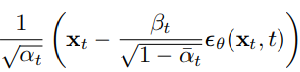

This is detailed by the following code snippet:

```
def predict_start_from_noise(self, x_t, t, noise):
  x_t_shape = tf.shape(x_t)
  return (self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape) * x_t
          - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape) * noise
          )

def p_mean_variance(self, pred_noise, x, t, clip_denoised=True):
        x_recon = self.predict_start_from_noise(x, t=t, noise=pred_noise)
        if clip_denoised:
            x_recon = tf.clip_by_value(x_recon, self.clip_min, self.clip_max)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t
        )
        return model_mean, posterior_variance, posterior_log_variance
```


### 2.  Sampling i.e. Reverse Diffusion

The Algorithm for sampling is detailed below:

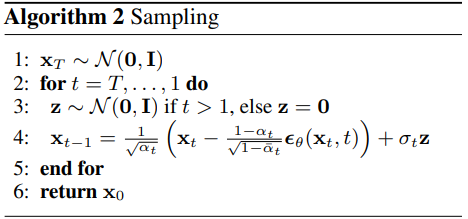

The generate_ images function (i.e. generates the images) is actually part of the Diffusion Model which is constructed later (see section 4. constructing the Diffusion  Model) but is needed here due to line 4 of the sampling algorithm as detailed by the following code snippet:


```
def p_sample(self, pred_noise, x, t, clip_denoised=True):
        """Sample from the diffusion model.

        Args:
            pred_noise: Noise predicted by the diffusion model
            x: Samples at a given timestep for which the noise was predicted
            t: Current timestep
            clip_denoised (bool): Whether to clip the predicted noise
                within the specified range or not.
        """
        model_mean, _, model_log_variance = self.p_mean_variance(
            pred_noise, x=x, t=t, clip_denoised=clip_denoised
        )
        noise = tf.random.normal(shape=x.shape, dtype=x.dtype)
        # No noise when t == 0
        nonzero_mask = tf.reshape(
            1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x)[0], 1, 1, 1]
        )
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise

def generate_images(self, num_images=16):
        # 1. Randomly sample noise (starting point for reverse process)
        samples = tf.random.normal(
            shape=(num_images, img_size, img_size, img_channels), dtype=tf.float32
        )
        # 2. Sample from the model iteratively
        for t in reversed(range(0, self.timesteps)):
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
            pred_noise = self.ema_network.predict(
                [samples, tt], verbose=0, batch_size=num_images
            )
            samples = self.gdf_util.p_sample(
                pred_noise, samples, tt, clip_denoised=True
            )
        # 3. Return generated samples
        return samples        
```


In [ ]:
class GaussianDiffusion:
    """Gaussian diffusion utility.

    Args:
        beta_start: Start value of the scheduled variance
        beta_end: End value of the scheduled variance
        timesteps: Number of time steps in the forward process
    """

    def __init__(
        self,
        beta_start=1e-4,
        beta_end=0.02,
        timesteps=1000,
        clip_min=-1.0,
        clip_max=1.0,
    ):
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps
        self.clip_min = clip_min
        self.clip_max = clip_max

        # Define the linear variance schedule
        self.betas = betas = np.linspace(
            beta_start,
            beta_end,
            timesteps,
            dtype=np.float64,  # Using float64 for better precision
        )
        self.num_timesteps = int(timesteps)

        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        self.betas = tf.constant(betas, dtype=tf.float32)
        self.alphas_cumprod = tf.constant(alphas_cumprod, dtype=tf.float32)
        self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype=tf.float32)

        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = tf.constant(
            np.sqrt(alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_one_minus_alphas_cumprod = tf.constant(
            np.sqrt(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.log_one_minus_alphas_cumprod = tf.constant(
            np.log(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_recip_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod), dtype=tf.float32
        )
        self.sqrt_recipm1_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod - 1), dtype=tf.float32
        )

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.posterior_variance = tf.constant(posterior_variance, dtype=tf.float32)

        # Log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = tf.constant(
            np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf.float32
        )

        self.posterior_mean_coef1 = tf.constant(
            betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

        self.posterior_mean_coef2 = tf.constant(
            (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod),
            dtype=tf.float32,
        )

    def _extract(self, a, t, x_shape):
        """Extract some coefficients at specified timesteps,
        then reshape to [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.

        Args:
            a: Tensor to extract from
            t: Timestep for which the coefficients are to be extracted
            x_shape: Shape of the current batched samples
        """
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        return tf.reshape(out, [batch_size, 1, 1, 1])

    def q_mean_variance(self, x_start, t):
        """Extracts the mean, and the variance at current timestep.

        Args:
            x_start: Initial sample (before the first diffusion step)
            t: Current timestep
        """
        x_start_shape = tf.shape(x_start)
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start_shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start_shape)
        log_variance = self._extract(
            self.log_one_minus_alphas_cumprod, t, x_start_shape
        )
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise):
        """Diffuse the data.

        Args:
            x_start: Initial sample (before the first diffusion step)
            t: Current timestep
            noise: Gaussian noise to be added at the current timestep
        Returns:
            Diffused samples at timestep `t`
        """
        x_start_shape = tf.shape(x_start)
        return (
            self._extract(self.sqrt_alphas_cumprod, t, tf.shape(x_start)) * x_start
            + self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_shape)
            * noise
        )

    def predict_start_from_noise(self, x_t, t, noise):
        x_t_shape = tf.shape(x_t)
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape) * x_t
            - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        """Compute the mean and variance of the diffusion
        posterior q(x_{t-1} | x_t, x_0).

        Args:
            x_start: Stating point(sample) for the posterior computation
            x_t: Sample at timestep `t`
            t: Current timestep
        Returns:
            Posterior mean and variance at current timestep
        """

        x_t_shape = tf.shape(x_t)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t_shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t_shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t_shape)
        posterior_log_variance_clipped = self._extract(
            self.posterior_log_variance_clipped, t, x_t_shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, pred_noise, x, t, clip_denoised=True):
        x_recon = self.predict_start_from_noise(x, t=t, noise=pred_noise)
        if clip_denoised:
            x_recon = tf.clip_by_value(x_recon, self.clip_min, self.clip_max)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t
        )
        return model_mean, posterior_variance, posterior_log_variance

    def p_sample(self, pred_noise, x, t, clip_denoised=True):
        """Sample from the diffusion model.

        Args:
            pred_noise: Noise predicted by the diffusion model
            x: Samples at a given timestep for which the noise was predicted
            t: Current timestep
            clip_denoised (bool): Whether to clip the predicted noise
                within the specified range or not.
        """
        model_mean, _, model_log_variance = self.p_mean_variance(
            pred_noise, x=x, t=t, clip_denoised=clip_denoised
        )
        noise = tf.random.normal(shape=x.shape, dtype=x.dtype)
        # No noise when t == 0
        nonzero_mask = tf.reshape(
            1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x)[0], 1, 1, 1]
        )
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise

### 3. Constructing Denoising Neural Network

As Aakash Kumar Nain states in the [tutorial](https://keras.io/examples/generative/ddpm/):

> U-Net, originally developed for semantic segmentation, is an architecture that is widely used for implementing diffusion models but with some slight modifications...[first], The network accepts two inputs: Image and time step
...[Second] Self-attention between the convolution blocks once we reach a specific resolution (16x16 in the paper)...[Lastly] Group Normalization instead of weight normalization

This is detailed by the following code snippets:

```
def build_model(
    img_size,
    img_channels,
    widths,
    has_attention,
    num_res_blocks=2,
    norm_groups=8,
    interpolation="nearest",
    activation_fn=keras.activations.swish,
):
    image_input = layers.Input(
        shape=(img_size, img_size, img_channels), name="image_input"
    )
    time_input = keras.Input(shape=(), dtype=tf.int64, name="time_input")

    return keras.Model([image_input, time_input], x, name="unet")
```

```
class AttentionBlock(layers.Layer):
    """Applies self-attention.

    Args:
        units: Number of units in the dense layers
        groups: Number of groups to be used for GroupNormalization layer
    """

    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)

        self.norm = layers.GroupNormalization(groups=groups)
        self.query = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.key = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.value = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.proj = layers.Dense(units, kernel_initializer=kernel_init(0.0))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)

        inputs = self.norm(inputs)
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)

        attn_score = tf.einsum("bhwc, bHWc->bhwHW", q, k) * scale
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height * width])

        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height, width])

        proj = tf.einsum("bhwHW,bHWc->bhwc", attn_score, v)
        proj = self.proj(proj)
        return inputs + proj

    # DownBlock
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
            skips.append(x)

    # UpBlock
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = layers.Concatenate(axis=-1)([x, skips.pop()])
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)   
```






In [ ]:
# Kernel initializer to use
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return keras.initializers.VarianceScaling(
        scale, mode="fan_avg", distribution="uniform"
    )


class AttentionBlock(layers.Layer):
    """Applies self-attention.

    Args:
        units: Number of units in the dense layers
        groups: Number of groups to be used for GroupNormalization layer
    """

    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)

        self.norm = layers.GroupNormalization(groups=groups)
        self.query = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.key = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.value = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.proj = layers.Dense(units, kernel_initializer=kernel_init(0.0))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)

        inputs = self.norm(inputs)
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)

        attn_score = tf.einsum("bhwc, bHWc->bhwHW", q, k) * scale
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height * width])

        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height, width])

        proj = tf.einsum("bhwHW,bHWc->bhwc", attn_score, v)
        proj = self.proj(proj)
        return inputs + proj


class TimeEmbedding(layers.Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.half_dim = dim // 2
        self.emb = math.log(10000) / (self.half_dim - 1)
        self.emb = tf.exp(tf.range(self.half_dim, dtype=tf.float32) * -self.emb)

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb


def ResidualBlock(width, groups=8, activation_fn=keras.activations.swish):
    def apply(inputs):
        x, t = inputs
        input_width = x.shape[3]

        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(
                width, kernel_size=1, kernel_initializer=kernel_init(1.0)
            )(x)

        temb = activation_fn(t)
        temb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(temb)[
            :, None, None, :
        ]

        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)

        x = layers.Add()([x, temb])
        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)

        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(0.0)
        )(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownSample(width):
    def apply(x):
        x = layers.Conv2D(
            width,
            kernel_size=3,
            strides=2,
            padding="same",
            kernel_initializer=kernel_init(1.0),
        )(x)
        return x

    return apply


def UpSample(width, interpolation="nearest"):
    def apply(x):
        x = layers.UpSampling2D(size=2, interpolation=interpolation)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)
        return x

    return apply


def TimeMLP(units, activation_fn=keras.activations.swish):
    def apply(inputs):
        temb = layers.Dense(
            units, activation=activation_fn, kernel_initializer=kernel_init(1.0)
        )(inputs)
        temb = layers.Dense(units, kernel_initializer=kernel_init(1.0))(temb)
        return temb

    return apply


def build_model(
    img_size,
    img_channels,
    widths,
    has_attention,
    num_res_blocks=2,
    norm_groups=8,
    interpolation="nearest",
    activation_fn=keras.activations.swish,
):
    image_input = layers.Input(
        shape=(img_size, img_size, img_channels), name="image_input"
    )
    time_input = keras.Input(shape=(), dtype=tf.int64, name="time_input")

    x = layers.Conv2D(
        first_conv_channels,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer=kernel_init(1.0),
    )(image_input)

    temb = TimeEmbedding(dim=first_conv_channels * 4)(time_input)
    temb = TimeMLP(units=first_conv_channels * 4, activation_fn=activation_fn)(temb)

    skips = [x]

    # DownBlock
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)
            skips.append(x)

        if widths[i] != widths[-1]:
            x = DownSample(widths[i])(x)
            skips.append(x)

    # MiddleBlock
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)(
        [x, temb]
    )
    x = AttentionBlock(widths[-1], groups=norm_groups)(x)
    x = ResidualBlock(widths[-1], groups=norm_groups, activation_fn=activation_fn)(
        [x, temb]
    )

    # UpBlock
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = layers.Concatenate(axis=-1)([x, skips.pop()])
            x = ResidualBlock(
                widths[i], groups=norm_groups, activation_fn=activation_fn
            )([x, temb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], groups=norm_groups)(x)

        if i != 0:
            x = UpSample(widths[i], interpolation=interpolation)(x)

    # End block
    x = layers.GroupNormalization(groups=norm_groups)(x)
    x = activation_fn(x)
    x = layers.Conv2D(3, (3, 3), padding="same", kernel_initializer=kernel_init(0.0))(x)
    return keras.Model([image_input, time_input], x, name="unet")

### 4.   Constructing the Diffusion Model

The training algorithm for the Diffusion Model is detailed below:



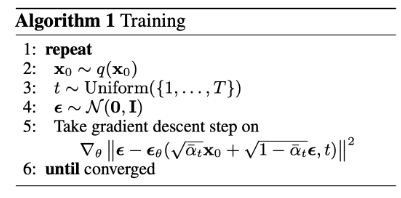









And the following code snippet details the training algorithm:



```
    def train_step(self, images):
        # 1. Get the batch size
        batch_size = tf.shape(images)[0]

        # 2. Sample timesteps uniformly
        t = tf.random.uniform(
            minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64
        )

        with tf.GradientTape() as tape:
            # 3. Sample random noise to be added to the images in the batch
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)

            # 4. Diffuse the images with noise
            images_t = self.gdf_util.q_sample(images, t, noise)

            # 5. Pass the diffused images and time steps to the network
            pred_noise = self.network([images_t, t], training=True)

            # 6. Calculate the loss
            loss = self.loss(noise, pred_noise)

        # 7. Get the gradients
        gradients = tape.gradient(loss, self.network.trainable_weights)

        # 8. Update the weights of the network
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        # 9. Updates the weight values for the network with EMA weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)

        # 10. Return loss values
        return {"loss": loss}
```





In [ ]:
class DiffusionModel(keras.Model):
    def __init__(self, network, ema_network, timesteps, gdf_util, ema=0.999):
        super().__init__()
        self.network = network
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util
        self.ema = ema

    def train_step(self, images):
        # 1. Get the batch size
        batch_size = tf.shape(images)[0]

        # 2. Sample timesteps uniformly
        t = tf.random.uniform(
            minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64
        )

        with tf.GradientTape() as tape:
            # 3. Sample random noise to be added to the images in the batch
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)

            # 4. Diffuse the images with noise
            images_t = self.gdf_util.q_sample(images, t, noise)

            # 5. Pass the diffused images and time steps to the network
            pred_noise = self.network([images_t, t], training=True)

            # 6. Calculate the loss
            loss = self.loss(noise, pred_noise)

        # 7. Get the gradients
        gradients = tape.gradient(loss, self.network.trainable_weights)

        # 8. Update the weights of the network
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        # 9. Updates the weight values for the network with EMA weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)

        # 10. Return loss values
        return {"loss": loss}

    def generate_images(self, num_images=16):
        # 1. Randomly sample noise (starting point for reverse process)
        samples = tf.random.normal(
            shape=(num_images, img_size, img_size, img_channels), dtype=tf.float32
        )
        # 2. Sample from the model iteratively
        for t in reversed(range(0, self.timesteps)):
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
            pred_noise = self.ema_network.predict(
                [samples, tt], verbose=0, batch_size=num_images
            )
            samples = self.gdf_util.p_sample(
                pred_noise, samples, tt, clip_denoised=True
            )
        # 3. Return generated samples
        return samples

    def plot_images(
        self, epoch=None, logs=None, num_rows=2, num_cols=8, figsize=(12, 5)
    ):
        """Utility to plot images using the diffusion model during training."""
        generated_samples = self.generate_images(num_images=num_rows * num_cols)
        generated_samples = (
            tf.clip_by_value(generated_samples * 127.5 + 127.5, 0.0, 255.0)
            .numpy()
            .astype(np.uint8)
        )

        _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
        for i, image in enumerate(generated_samples):
            if num_rows == 1:
                ax[i].imshow(image)
                ax[i].axis("off")
            else:
                ax[i // num_cols, i % num_cols].imshow(image)
                ax[i // num_cols, i % num_cols].axis("off")

        plt.tight_layout()
        plt.show()

# Denosing Diffusion Implicit Models

 [Denosing Diffusion Implicit Models](https://arxiv.org/abs/2010.02502) is an improvement to Denosing Diffusion Probabillistic Models especially when it comes to sampling. The DDIM model has been constructed using the keras library as detailed by [András Béres](https://keras.io/examples/generative/ddim/)

As András Béres states:

> **Diffusion refers to the process of turning a structured signal (eg., an image) into noise.** By simulating diffusion, we can generate noisy images from our training images, and can train a neural network to try to denoise them. **Using the trained network we can simulate the opposite of diffusion, reverse diffusion, which is the process of an image emerging from noise.**


### 1. Kernel Inception Distance (KID)

Before getting to the actual model the evaluation of the image generation quality (i.e. metric) produced by the model is exapleind

> As detailed by [Demystifying MMD GANS](https://arxiv.org/pdf/1801.01401.pdf)
the Kernel Inception Distance is the squared version of Maxium Mean Discrepancy (MMD) between Inception model representations. In which a polynomial kernel

\begin{align}
 k(x,y)=(\frac{1}{d}{x}^{T}y+1)^3
\end{align}

> where d is the representation dimension. This equation can also be viewed as a MMD directly on the input image with the kernel

\begin{align}
 K(x,y)=k(\phi(x), \phi(y))
\end{align}

> where Φ is the function mapping images to the inception representation. Compared to the FID, the KID has several advantages. First, it does not
assume a parametric form for the distribution of activations. With the cubic kernel we use here, the KID compares skewness as well as the mean and variance.
Also, unlike the FID, the KID has a simple unbiased estimator.It also shares the behavior of the FID as artifacts are added to images.



In [ ]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
# data
dataset_name = "oxford_flowers102"
dataset_repetitions = 5
num_epochs = 50
image_size = 64
# KID = Kernel Incption Distance
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

# Data Pre-processing: balance the training and validation sets on the
# Oxford flower dataset https://www.tensorflow.org/datasets/catalog/oxford_flowers102

def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


# load dataset
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

# Implementation of KID evaluation metric

class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        # encoding real images
        real_features = self.encoder(real_images, training=False)
        # encoding generated images
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        # KID computation
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

### 2. Constructing Denoising Neural Network

The Denoising Neural Network is used for denoising and is incorporated into the Diffusion model as detailed in the next section.

 As András Béres states:

> We build a **U-Net** with identical input and output dimensions. U-Net is a popular semantic segmentation architecture, **whose main idea is that it progressively downsamples and then upsamples its input image, and adds skip connections between layers having the same resolution**. These help with gradient flow and avoid introducing a representation bottleneck.



> The network takes two inputs, the noisy images and the variances of their noise components. The latter is required since denoising a signal requires different operations at different levels of noise. **We transform the noise variances using sinusoidal embeddings**.This helps the network to be highly sensitive to the noise level, which is crucial for good performance. We implement sinusoidal embeddings using a Lambda layer.








In [ ]:
# sinusoidal embedding function
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
            x = layers.BatchNormalization(center=False, scale=False)(x)
            x = layers.Conv2D(width, kernel_size=3, padding="same", activation=keras.activations.swish)(x)
            x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
            x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

# creation of the U-Net network
def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")

### 3. Constructing the Diffusion Model

Before implementing the Diffusion Model two important concepts related to these types of models must be explained. First is the Diffusion Schedule and the second is the type of sampling procedure (aka reverse diffusion) used.

*   Diffusion Schedule

  As András Béres states:

  > We need to have a function that tells us at each point in the diffusion process the noise levels and signal levels of the noisy image corresponding to the actual diffusion time. This will be called the diffusion schedule.We generate the noisy image by weighting the random noise and the training image by their corresponding rates and adding them together. In András Béres implementation he used a simplified version of the cosine schedule, using the transformation from diffusion times into angles and then into signal and noise rates.

*   Sampling (reverse diffusion)

  As András Béres states:

  > When sampling (i.e., reverse_diffusion), at each step we take the previous estimate of the noisy image and separate it into image and noise using our network. Then we recombine these components using the signal and noise rate of the following step.





In [ ]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps
        )
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()

### 4. Training Loop



In [ ]:
# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)
model.compile(
    optimizer=keras.optimizers.experimental.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# pixelwise mean absolute error is used as loss

# save the best model based on the validation KID metric
checkpoint_path = "checkpoints/diffusion_model"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)